#### **Fig05_Reference_Run.ipynb**

**Simulate energy costs for one week (15 min steps)**

In [1]:
# ─── Setup & Helpers ───
import os, copy
from datetime import timedelta
import pandas as pd, numpy as np, pandapower as pp, simbench as sb
import matplotlib.pyplot as plt

# 1. Timesteps & Date Range (15 min steps, one week)
timestep_start = 7584
simulation_steps = 672  # 96×7
timestep_end = timestep_start + simulation_steps
start_date = pd.Timestamp("2024-01-01")
date_from = start_date + timedelta(minutes=15 * timestep_start)
date_to   = start_date + timedelta(minutes=15 * timestep_end)
print("Sim period:", date_from, "→", date_to)

# 2. Load spot‑market prices
def get_energy_prices(year):
    fn = os.path.join("..", "data", f"{year}_spotmarket.csv")
    if not os.path.exists(fn):
        raise FileNotFoundError(f"{fn} not found")

    df = pd.read_csv(fn, sep=';', index_col=0)
    df.index = pd.to_datetime(df.index.astype(str) + " " + df.von, format='%d.%m.%Y %H:%M')

    df['price'] = df['Spotmarktpreis in ct/kWh'].str.replace(',', '.').astype(float)

    # Remove duplicate timestamps before resampling
    df = df.loc[~df.index.duplicated(keep='first')]

    # Forward fill to 15-minute resolution
    df = df[['price']].resample('15min').ffill().loc[f'{year}-01-01':]

    # Optional: save processed file
    df.to_csv(os.path.join("..", "data", f"spotmarket_reduced_{year}.csv"))
    return df.price.to_numpy()

# 3. Manual transformer‑loading calculators
def manual_calc_power(i_hv,i_lv,vmh,vml,vn_hv,vn_lv,sn_mva):
    S = lambda v,i: np.sqrt(3)*v*i
    return max(S(vmh*vn_hv,i_hv), S(vml*vn_lv,i_lv)) / sn_mva * 100

def manual_calc_current(i_hv,i_lv,vn_hv,vn_lv,sn_hv,sn_lv,par=1,df=1):
    S = lambda vn,i: np.sqrt(3)*vn*i
    return max(S(vn_hv,i_hv)/sn_hv, S(vn_lv,i_lv)/sn_lv) * 100 / par / df

# 4. Grid & profiles
energy_prices = get_energy_prices(2024)
net = sb.get_simbench_net("1-LV-rural1--1-sw")
assert not sb.profiles_are_missing(net)
profiles = sb.get_absolute_values(net, profiles_instead_of_study_cases=True)
profiles_load_p = profiles[("load","p_mw")]
profiles_load_q = profiles[("load","q_mvar")]
profiles_sgen_p = profiles[("sgen","p_mw")]

# Prepare base network
net_temp = pp.pandapowerNet(net)
net_temp.ext_grid.vm_pu = 1

/home/iai/ii6824/eGridLVOpt_env/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


Sim period: 2024-03-20 00:00:00 → 2024-03-27 00:00:00


##### 2. Helper functions

In [2]:
# ─── Simulation & Post‑processing ───
results = []
energy_costs_bus_sum = [0]

for step in range(simulation_steps):
    t = timestep_start + step

    # Update profiles
    for i in net_temp.load.index:
        net_temp.load.at[i, "p_mw"]  = profiles_load_p.iloc[t, i]
        net_temp.load.at[i, "q_mvar"] = profiles_load_q.iloc[t, i]
    for i in net_temp.sgen.index:
        net_temp.sgen.at[i, "p_mw"] = profiles_sgen_p.iloc[t, i]
    for i in net_temp.storage.index:
        net_temp.storage.at[i, "p_mw"] = 0

    # --- Simulation A: default transformer ---
    net_a = copy.deepcopy(net_temp)
    pp.runpp(net_a, trafo_loading="power")

    pv_sum  = net_a.res_sgen.p_mw.sum()
    load_sum = net_a.res_load.p_mw.sum()
    net_power_balance = pv_sum - load_sum
    net_bus = net_a.res_bus.p_mw.iloc[0]
    energy_costs_bus = net_bus * energy_prices[t] * 1000 * (15/60)

    energy_costs_bus_sum.append(energy_costs_bus_sum[-1] + energy_costs_bus)

    # Manual vs pandapower transformer loading (power & current)
    i_hv, i_lv = net_a.res_trafo.i_hv_ka[0], net_a.res_trafo.i_lv_ka[0]
    vmh, vml   = net_a.res_trafo.vm_hv_pu[0], net_a.res_trafo.vm_lv_pu[0]
    vh, vl     = net_a.trafo.vn_hv_kv[0], net_a.trafo.vn_lv_kv[0]
    snA        = net_a.trafo.sn_mva[0]

    a_pp_pow  = net_a.res_trafo.loading_percent[0]
    a_calc_pow = manual_calc_power(i_hv,i_lv,vmh,vml,vh,vl,snA)
    pp.runpp(net_a, trafo_loading="current")
    par = net_a.trafo.parallel.iloc[0] if 'parallel' in net_a.trafo else 1
    df_ = net_a.trafo.df.iloc[0] if 'df' in net_a.trafo else 1
    a_pp_cur   = net_a.res_trafo.loading_percent[0]
    a_calc_cur = manual_calc_current(i_hv,i_lv,vh,vl,snA,snA,par,df_)

    # --- Simulation B: reduced transformer rating ---
    net_b = copy.deepcopy(net_temp)
    net_b.trafo.at[0, "sn_mva"] = 0.25
    pp.runpp(net_b, trafo_loading="power")
    b_pp_pow  = net_b.res_trafo.loading_percent[0]
    b_calc_pow = manual_calc_power(i_hv,i_lv,vmh,vml,vh,vl,0.25)
    pp.runpp(net_b, trafo_loading="current")
    b_pp_cur   = net_b.res_trafo.loading_percent[0]
    b_calc_cur = manual_calc_current(i_hv,i_lv,vh,vl,0.25,0.25,par,df_)

    # Store results
    results.append({
        "time_step": step, 
        "pv_sum": pv_sum, 
        "load_sum": load_sum,
        "net_power_balance": net_power_balance, 
        "net_bus": net_bus,
        "energy_costs": net_power_balance * energy_prices[t] * 1000 * (15 / 60),
        "energy_costs_bus": energy_costs_bus,
        "cum_energy_costs": energy_costs_bus_sum[-1],
        "A_pp_pow": a_pp_pow, "A_calc_pow": a_calc_pow,
        "A_pp_cur": a_pp_cur, "A_calc_cur": a_calc_cur,
        "B_pp_pow": b_pp_pow, "B_calc_pow": b_calc_pow,
        "B_pp_cur": b_pp_cur, "B_calc_cur": b_calc_cur
    })

# Build DataFrame
df_results = pd.DataFrame(results)

In [3]:
# Prepare values from df_results and the price vector
power_kW = df_results.net_bus * 1000  # Convert MW to kW
price_euro = energy_prices[timestep_start:timestep_end] / 100  # Convert ct/kWh to €/kWh
scaled_time = 15 / 60  # Convert 15-minute intervals to hours

# Energy cost calculation without storage and heat pump control
money_spend_sum_no_storage = energy_costs_bus_sum[-1]  # Last value from accumulated cost list
money_spend_sum_no_storage = np.floor(money_spend_sum_no_storage) / 100  # Round down to two decimals

# Alternative calculation for verification using price × power
costs = (power_kW * price_euro) * scaled_time  # Per-timestep energy costs
calc_accumulated_costs = np.cumsum(costs)
money_spend_sum_check = np.floor(calc_accumulated_costs.iloc[-1] * 100) / 100  # Rounded reference value

# Output both values for comparison
print(f"Energy costs (from accumulation list):  {money_spend_sum_no_storage:.2f} €")
print(f"Energy costs (via recomputation):       {money_spend_sum_check:.2f} €")

# Define the output directory for storing results
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "results"))
storage_dir = os.path.join(parent_dir, "costs_no_storage")
os.makedirs(storage_dir, exist_ok=True)  # Ensure the directory exists

# Save the computed energy cost to file
file_path = os.path.join(storage_dir, f"{timestep_start}-{timestep_end}_money_spend_sum_no_storage.npy")
np.save(file_path, money_spend_sum_no_storage)

print(f"Energy cost without MPC-based storage and heat pump control has been saved to:\n{file_path}")

Energy costs (from accumulation list):  88.34 €
Energy costs (via recomputation):       88.34 €
Energy cost without MPC-based storage and heat pump control has been saved to:
/hkfs/home/haicore/iai/ii6824/Documents/eGridLVOpt/results/costs_no_storage/7584-8256_money_spend_sum_no_storage.npy


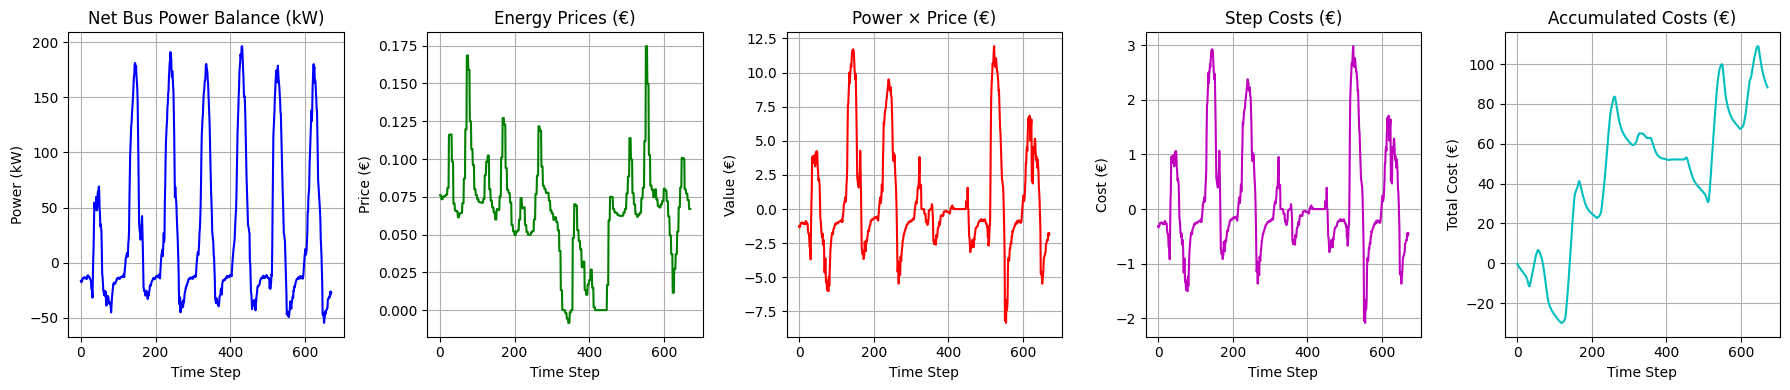

In [4]:
# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(18, 4), sharex=True)

axes[0].plot(power_kW, linestyle='-', color='b')
axes[0].set_title("Net Bus Power Balance (kW)")
axes[0].set_xlabel("Time Step")
axes[0].set_ylabel("Power (kW)")
axes[0].grid(True)

axes[1].plot(price_euro, linestyle='-', color='g')
axes[1].set_title("Energy Prices (€)")
axes[1].set_xlabel("Time Step")
axes[1].set_ylabel("Price (€)")
axes[1].grid(True)

axes[2].plot(power_kW * price_euro, linestyle='-', color='r')
axes[2].set_title("Power × Price (€)")
axes[2].set_xlabel("Time Step")
axes[2].set_ylabel("Value (€)")
axes[2].grid(True)

axes[3].plot(costs, linestyle='-', color='m')
axes[3].set_title("Step Costs (€)")
axes[3].set_xlabel("Time Step")
axes[3].set_ylabel("Cost (€)")
axes[3].grid(True)

axes[4].plot(calc_accumulated_costs, linestyle='-', color='c')
axes[4].set_title("Accumulated Costs (€)")
axes[4].set_xlabel("Time Step")
axes[4].set_ylabel("Total Cost (€)")
axes[4].grid(True)

plt.tight_layout()
plt.show()